## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# import ignore ; 

## Read Data

In [116]:
# 구매 데이터 읽기
purchase = pd.read_csv('../data/DC_구매내역정보.csv', parse_dates=['구매일자'], encoding='cp949')
print('데이터 크기:', purchase.shape)

데이터 크기: (101325, 12)


In [3]:
purchase.sample(5)

,ID,상품대분류명,상품중분류명,구매지역,구매일자,구매시간,구매수량,구매금액,취소여부,증정상품,거래ID,매장ID
66933,543456305,식품,축산물,경기 안양시,2014-12-21 16:00:00,16,1,18000,0,0,21903,백화점
16170,634438222,가전제품,TV/AV,부산 사하구,2014-09-11 12:00:00,12,1,62000,0,0,25513,하이마트
79429,587867224,식품,가공식품,서울 노원구,2014-09-09 18:00:00,18,1,3000,0,0,23861,백화점
39666,518914145,식품,건강식품,경기 안양시,2014-09-07 14:00:00,14,1,64000,0,0,20972,백화점
59901,997144126,생활잡화,화장품,서울 송파구,2014-04-06 16:00:00,16,-1,-31000,1,0,40678,백화점


## 취소 여부
`질문` 롯데 계열사의 반품 및 환불 기간은 7일로 되어있다. 그 기간 이상 걸린 데이터는 무엇일까? 
- 재방문 후 환불을 해야 하는 백화점과 달리<br>
  기사가 방문해 수거하여 수거와 정상 확인 등으로 환불일자가 7일 이후로 된 것일까 추측해보았다.

In [4]:
refunds = purchase.query('취소여부==1')
print('환불 건수: ', refunds.shape[0])

환불 건수:  8345


In [5]:
bindexs, period = [], []

for rindex, ID, DATE, PRODUCT, COUNT, AMOUNT in refunds[['ID','구매일자','상품중분류명','구매수량','구매금액']].itertuples():
    dates = purchase.query('ID == @ID and 구매일자 <= @DATE and 상품중분류명 == @PRODUCT\
                            and 구매수량 >= -1*@COUNT and 구매금액/구매수량 == @AMOUNT/@COUNT')['구매일자']\
            .sort_values(ascending=False).reset_index()
    if dates.shape[0] > 0:
        for _, bindex, bday in dates.itertuples():
            if bindex not in bindexs:
                bindexs.append(bindex)
                period.append((DATE - bday).days)
                break
    # 구매데이터가 누락된 경우이면 np.nan을 저장한다.
    else:
        bindexs.append(np.nan)
        period.append(np.nan)

In [117]:
# 구매데이터가 누락된 경우는 2014개이다.
trans = pd.DataFrame([refunds.index.values, bindexs, period, refunds['매장ID']]).T
trans.columns = ['환불', '구매', '기간', '환불매장ID']
trans = trans.merge(purchase.loc[trans.구매.dropna(),'매장ID'].reset_index().rename(columns={'index':'구매','매장ID':'구매매장ID'}),
                   on='구매', how='left')
display(trans.notna().sum())

환불        8345
구매        6331
기간        6331
환불매장ID    8345
구매매장ID    6331
dtype: int64

In [118]:
# 환불매장과 구매매장ID가 다른 경우 중 한 쪽이 백화점이면 반드시 반대도 백화점이다. 이를 반영해 수정한다.
# 추후 원본데이터(purchase)에도 반영해야 한다.
trans['구매매장ID'] = trans[['환불매장ID','구매매장ID']].apply(lambda x: "백화점" if x[0]=="백화점" and x[1]=="하이마트" else x[1], axis=1)
trans['환불매장ID'] = trans[['구매매장ID','환불매장ID']].apply(lambda x: "백화점" if x[0]=="백화점" and x[1]=="하이마트" else x[1], axis=1)
display(trans['구매매장ID'].value_counts())

백화점     6278
하이마트      53
Name: 구매매장ID, dtype: int64

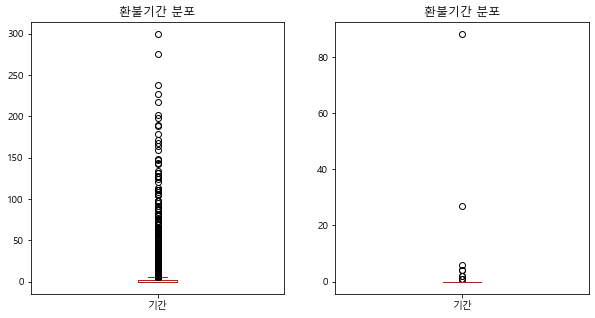

In [57]:
# 환불까지 7일 이상 걸리는 데이터가 백화점에서 많이 발생하며 환불상품군도 음료, 의류잡화이기에 sampling 오류라고 본다.
fig, ax = plt.subplots(1, 2, figsize=(10,5))
trans.query('구매매장ID=="백화점"')['기간'].plot.box(title="환불기간 분포", color='firebrick',ax=ax[0])
trans.query('구매매장ID=="하이마트"')['기간'].plot.box(title="환불기간 분포", color='firebrick',ax=ax[1])
plt.show()

In [119]:
# [DC] 환불기간이 7일을 넘는 데이터는 제거한다.
print('7일 이후 환불 건수:', trans.query('기간 > 7').shape[0])

purchase.drop(trans.query('기간 > 7').구매.tolist() + trans.query('기간 > 7').환불.tolist(), inplace=True)
print('구매데이터 크기:', purchase.shape[0])

7일 이후 환불 건수: 579
구매데이터 크기: 100167


In [120]:
# 환불, 구매 정보를 담고 있는 테이블에도 수정을 반영한다.
trans = trans.drop(trans.query('기간 > 7').index)
print('환불정보 데이터 크기:', trans.shape[0])
display(trans.isna().sum())

환불정보 데이터 크기: 7766


In [ ]:
# [DC] 원본데이터에도 매장ID 변경을 반영한다.
print('-------변경 전 매장별 거래건수-------')
display(purchase.매장ID.value_counts())

shop = trans[['환불','환불매장ID']].values.tolist() + trans[['구매','구매매장ID']].dropna().values.tolist()
shop += purchase.loc[set(purchase.index) - set(list(zip(*shop))[0]),'매장ID'].reset_index().values.tolist()
purchase['매장ID'] = pd.DataFrame(shop).sort_values(by=0)[1].values
print('-------변경 후 매장별 거래건수-------')
display(purchase.매장ID.value_counts())

In [149]:
# [DC] 구매ID, 환불기간을 추가한다.
ease = trans.dropna()[['환불','구매','기간']]
ease['구매거래ID'] = purchase.loc[ease.구매,'거래ID'].values
purchase = purchase.reset_index().merge(ease[['환불','기간','구매거래ID']], left_on='index', right_on='환불', how='left')
purchase.index = purchase['index'].values
purchase.drop(['index','환불'], axis=1, inplace=True)

`질문` 2014개의 구매데이터 누락 데이터는 2013년 말에 구매한 상품을 2014년에 환불한 경우일까?
- 해당 건수를 알아본 결과 예상대로 1월에 구매데이터가 누락된 환불건수가 많았다.
- 1월 외에도 구매 데이터가 누락된 건수는 `1838건`, 금액은 `3억 4천만원` 정도이다.
- 전부 제거하면 매출이 급상승할 것이다. 월별 성과를 매출로 보면 환불도 포함해야 한다.
- 제거하지 않을 경우 자연적으론 발생할 수 없는 환불만 한 고객이 생겨난다.
- 반대로 누락데이터를 지우면 실제론 환불했으나 환불 안한 것처럼 나온다.

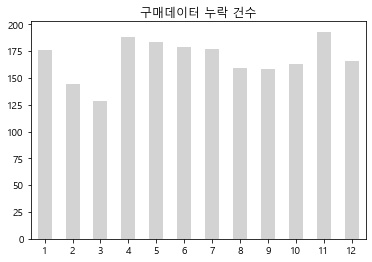

In [176]:
purchase.query('취소여부==1 and 기간.isna()')['구매일자'].dt.month.value_counts().sort_index()\
.plot.bar(title="구매데이터 누락 건수", rot=0, color='lightgray')
plt.show()

In [179]:
print('1월 외 누락데이터 건수:', purchase.query('취소여부==1 and 기간.isna() and 구매일자 > "2014-02-01"').shape[0])
print('1월 외 누락데이터 금액(단위: 천원):', \
      purchase.query('취소여부==1 and 기간.isna() and 구매일자 > "2014-02-01"')['구매금액'].sum()*-1//1000)

1월 외 누락데이터 건수: 1838
1월 외 누락데이터 금액(단위: 천원): 347155


In [188]:
purchase.drop(purchase.query('취소여부==1 and 기간.isna() and 구매일자 <= "2014-01-06"').index)\
.groupby('ID')['구매금액'].sum().sort_values().iloc[:15]

ID
647610673   -46228000
326615905    -2531000
336202470    -1913000
283656473    -1818000
973380801     -994000
501663896     -181000
556672595     -153000
859336555      -49000
522549235      -12000
459734645           0
948777438        2000
760598172        3000
316180538        4000
175105668        5000
444120706        5000
Name: 구매금액, dtype: int64

In [191]:
purchase.query('ID==522549235')

,ID,상품대분류명,상품중분류명,구매지역,구매일자,구매시간,구매수량,구매금액,취소여부,증정상품,거래ID,매장ID,기간,구매_거래ID
53397,522549235,의류잡화,여성용의류-정장류,서울 중구,2014-09-13 15:00:00,15,1,27000,0,0,21033,백화점,NaN,NaN
53398,522549235,의류잡화,여성용의류-정장류,서울 중구,2014-09-13 15:00:00,15,1,44000,0,0,21033,백화점,NaN,NaN
66643,522549235,의류잡화,여성용의류-SPA,서울 중구,2014-10-23 16:00:00,16,-1,-103000,1,0,21036,백화점,0,21671.0
66644,522549235,의류잡화,여성용의류-정장류,서울 중구,2014-09-14 16:00:00,16,-1,-27000,1,0,21034,백화점,NaN,NaN
66645,522549235,의류잡화,여성용의류-정장류,서울 중구,2014-09-14 16:00:00,16,1,27000,0,0,21034,백화점,NaN,NaN
66646,522549235,가전제품,주방가전,서울 중구,2014-09-14 17:00:00,17,1,28000,0,0,21034,백화점,NaN,NaN
66647,522549235,의류잡화,여성용의류-정장류,서울 중구,2014-09-14 17:00:00,17,-1,-43000,1,0,21034,백화점,0,21709.0
66648,522549235,의류잡화,여성용의류-정장류,서울 중구,2014-09-14 17:00:00,17,-1,-27000,1,0,21034,백화점,0,21681.0
66649,522549235,의류잡화,여성용의류-정장류,서울 중구,2014-10-26 16:00:00,16,-1,-52000,1,0,21037,백화점,0,21681.0
66650,522549235,의류잡화,여성용의류-정장류,서울 중구,2014-10-26 16:00:00,16,-1,-18000,1,0,21037,백화점,0,21681.0


In [184]:
(purchase.groupby('ID')['구매금액'].sum().sort_values() <= 0).sum()

11

In [186]:
purchase.groupby('ID')['구매금액'].sum().sort_values().iloc[:15]

ID
647610673   -46228000
326615905    -2531000
336202470    -1913000
283656473    -1818000
973380801     -994000
36304587      -237000
501663896     -181000
556672595     -153000
859336555      -49000
522549235      -12000
459734645           0
948777438        2000
760598172        3000
316180538        4000
175105668        5000
Name: 구매금액, dtype: int64